<a href="https://colab.research.google.com/github/MinghanChu/DeepLearning-ZerosToGans/blob/main/Image_Generation_using_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Generative Adversarial Networks (GANs) in PyTorch

To train neural networks, you need to use GPU to accelerate the training speed.

CUDA (Compute Unified Device Architecture) drivers are indeed widely used in the context of training neural networks, particularly with NVIDIA GPUs.

`NVDIA CUDA drivers` in a computer system allow the operating system and other software to communicate with hardware devices. They act as intermediaries, translating high-level commands from the operating system into low-level instructions that the hardware can understand.

The CUDA driver relies on the **underlying graphics driver** to manage the hardware. For CUDA applications to run correctly, the installed graphics driver must support the version of CUDA being used.

# Generative Modeling

Deep neural networks are used mainly for supervised learning: **classification or regression**. However, GANs use neural netweroks for a very different purpose.

1. GANs modeling is an unsupervised learning task in machine learning that involves automatically discovering an learning the regularities or patterns in input data in such a way that the model can be used to generate or ouptut new examples that plausibly could have been drawn from the original dataset.

Note unsupervised machine learning models don't require **labels or targets**.

The [Anime Face Dataset](https://github.com/bchao1/Anime-Face-Dataset), which consists of over 63,000 cropped anime faces. Note that generative modeling is an unsupervised learning task, so the images **do not have any labels**.

In [1]:
project_name = 'Iden_images'

Downloading

In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: username
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:13<00:00, 31.2MB/s]


In [8]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


list the first 10 entries in the directory specified by `DATA_DIR + '/images'`

In [11]:
print(os.listdir(DATA_DIR+'/images')[:10])

['54601_2016.jpg', '28972_2010.jpg', '30992_2010.jpg', '4138_2002.jpg', '333_2000.jpg', '59069_2018.jpg', '51979_2015.jpg', '34331_2011.jpg', '41364_2013.jpg', '15210_2006.jpg']


use `ImageFolder` class from `torchvision` library.

In [4]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

`stats`: mean of 0.5 and standard deviation of 0.5 are used to normalize the data

`image_size`: 64 x 64

In [5]:
impage_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

+ `T`: refers to torch version transform

+ `compose`: compose a bunch of transforms

+ `resize`: resize each image to 64 x 64 pixels

**Normalization**

The `*stats` syntax unpacks the stats tuple into two separate arguments for the `T.Normalize` function. So, `T.Normalize(*stats)` is equivalent to:

+ `T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))`

`T.Normalize(mean, std)` normalizes an image with the following formula for each channel:

```
output = (input−mean)/std
```

This will ensure that pixel values are in the range `(-1, 1)`.

For example, the minimum pixel value when the original pixel value is 0:

```
(0-0.5)/0.5 = -1
```

and the maximum pixel value when the original pixel value is 1:

```
(1-0.5)/0.5 = 1
```

**Why Normalize**

1. **Stabilizing Training**: By bringing pixel values to a similar range, it makes the model training process more stable and faster.

2. **Improving Convergence**: It helps in better and faster convergence of the model during training.



In [9]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(impage_size),
    T.CenterCrop(impage_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=3,
                      pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


create a helper function to denormalize the image tensors and display some sample impages from a training batch.

In [10]:
import torch
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
%matplotlib inline

**Applying denormalization**

The denormalization formula:

```
Recall: normalized_value = (original_value - mean)/std

To denormalize, we reverse the process:

original_value = normalized_value x std + mean
```


To review the image later we need to reconvert them into the `[0 1]` range. The expression `img_tensors * stats[1][0] + stats[0][0]` denormalizes the image tensor for the first channel (Red channel) using the above formula.


+ `stats[0]` refers to the first tuple `(0.5, 0.5, 0.5)`, which represents the mean values for the RGB channels.

+ `stats[1]` refers to the second tuple `(0.5, 0.5, 0.5)`, which represents the standard deviation values for the RGB channels.

Accessing specific elements

+ `stats[1][0]` accesses the first element of the second **tuple** in stats
+ `stats[1]` gives us the second tuple: `(0.5, 0.5, 0.5)`
+ `stats[1][0]` gives us the first element of this tuple: `0.5`

So, `stats[1][0]` refers to the standard deviation value for the **Red channel.**

General explanation

+ `stats[1]` accesses the tuple containing the standard deviations: `(0.5, 0.5, 0.5)`

+ `stats[1][0]` accesses the first value in this tuple, which is `0.5`


In [13]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

+ `images.detach()[:nmax]`: Detaches the images from the computation graph (useful if images are part of a computational graph in PyTorch) and selects up to nmax images.

+ `denorm(images.detach()[:nmax])`: Applies a denormalization function to the images to convert them back to their original range (assuming they were normalized earlier).

+ `make_grid(..., nrow=8)`: Arranges the images into a grid with 8 images per row.

+ `.permute(1, 2, 0)`: Changes the order of dimensions from (batch_size, channels, height, width) to (height, width, channels), which is required by imshow for correct color display.

+ `ax.imshow(...)`: Displays the grid of images on the axes.

+ `dl:` A DataLoader that provides batches of images.

+ `nmax:` The maximum number of images to display (default is 64).

+ `for images, _ in dl::` Iterates over batches from the DataLoader. Each batch is a tuple where images are the image tensors and _ is the corresponding labels (which are ignored here).



In [14]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


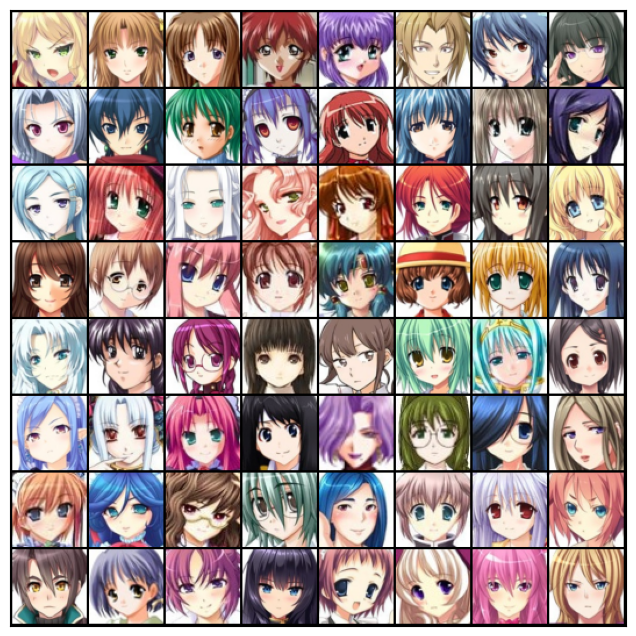

In [15]:
show_batch(train_dl)